In [2]:
import pandas as pd 
import matplotlib 
import matplotlib.pyplot as plt 
import seaborn as sbn
import numpy as np
import pymc3 as mc
from ipywidgets import interact
from IPython.display import HTML
import statsmodels as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
%matplotlib inline

In [3]:
counties = pd.read_csv("counties_combined.csv")
states   = pd.read_csv("states_combined.csv")

### Calculate total fertility rate per year and state 

In [4]:
tfr = states.groupby(['State','Year']).sum()["Fertility Rate"].div(1000.)
tfr.head()

State    Year  
Alabama  2008.0    2.019456
         2009.0    1.939580
         2010.0    1.861556
         2011.0    1.829351
         2012.0    1.799279
Name: Fertility Rate, dtype: float64

### Fertility evolution per state

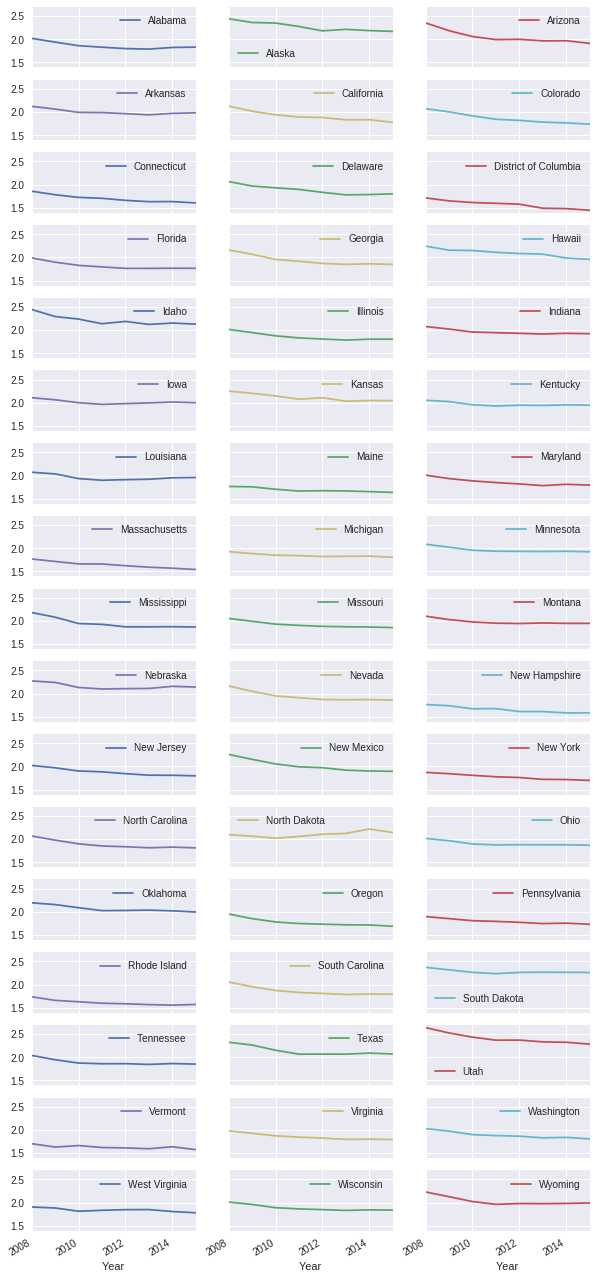

In [7]:
(tfr.unstack(level=0)
        .plot(subplots=True, 
              layout=(17,3 ), 
              figsize=(10, 25),
              sharey=True,
              sharex=True
              ));

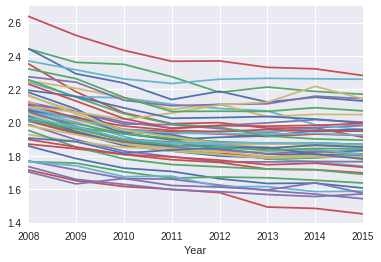

In [8]:
(tfr.unstack(level=0)
    .plot(legend=False));

### Distribution of TFR by year

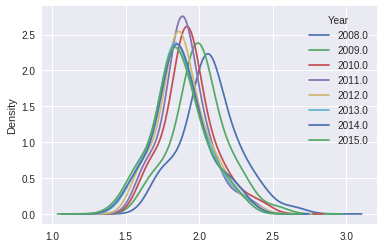

In [9]:
tfr.unstack(level=1).plot(kind='density')

In [10]:
tfr.to_csv('state_tfr.csv')

### State level Geo Distribution

In [11]:
HTML('<iframe width="100%" height="520" frameborder="0" src="https://team.carto.com/u/stuartlynn/builder/fd28d1f4-f490-11e6-90a6-0e05a8b3e3d7/embed" allowfullscreen webkitallowfullscreen mozallowfullscreen oallowfullscreen msallowfullscreen></iframe>')

## County level results

In [12]:
gaz = pd.read_csv("2016_Gaz_counties_national.txt", encoding='utf-8')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xf1 in position 20: invalid continuation byte

In [ ]:
tfr_counties = counties.groupby(['County','Year']).sum()["Fertility Rate"].div(1000.)
tfr_counties.head()

In [ ]:
tfr_counties.unstack(level=1).plot(kind='density')

In [ ]:
(tfr_counties.unstack(level=0)
    .plot(legend=False, c='grey', alpha=0.3,lw=0.3 ));

In [ ]:
tfr_counties.to_csv('tfr_counties.csv',header=True)

In [ ]:
tfr_counties

# Modeling

In [ ]:
average_tfr = (tfr.unstack(1).sum()/51.)

In [ ]:
average_tfr

In [ ]:
plt.acorr(average_tfr.index, average_tfr.as_matrix(), maxlags=6)

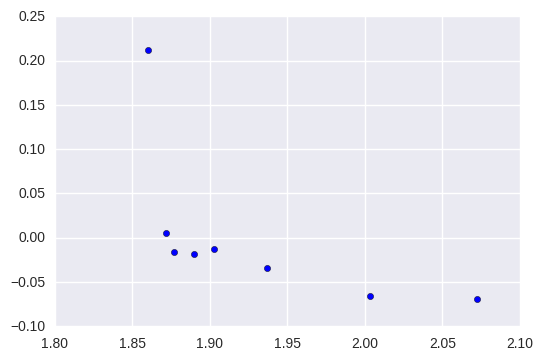

In [142]:
diffs = np.array([[ average_tfr.as_matrix()[index-1],a - average_tfr.as_matrix()[index-1]] for index, a in enumerate(average_tfr)])

plt.scatter(diffs[:,0],diffs[:,1])

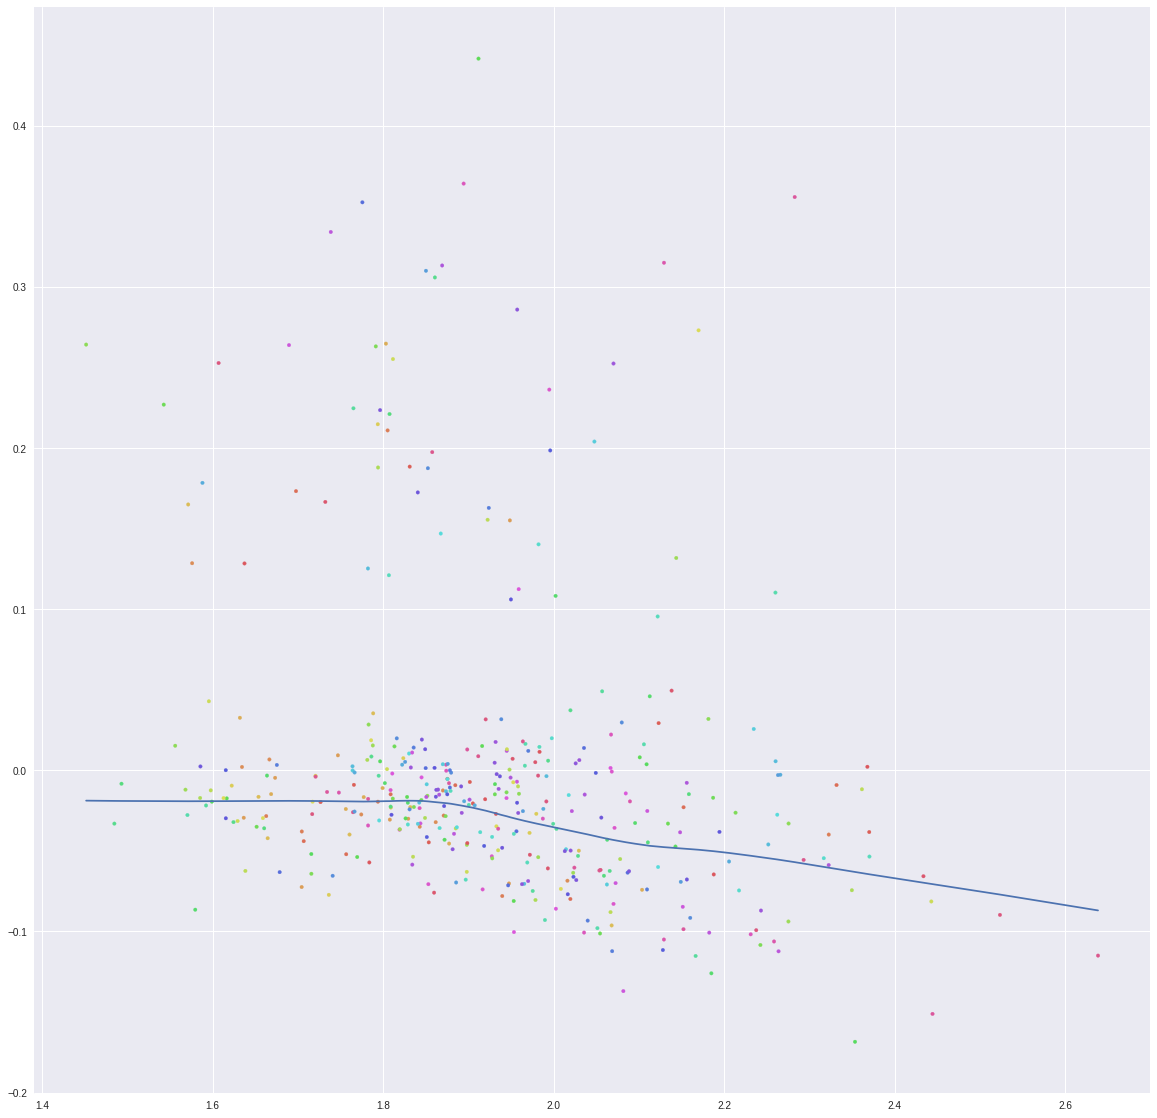

In [159]:
state_diffs = []
colors  = []

b= sbn.color_palette("hls", 51)
color_dict =  dict(zip(tfr.index.levels[0] , b  ))
point_states = []


state_list = tfr.index.get_level_values(0)
state_dict = dict(zip( np.unique(state_list),range(len(np.unique(state_list)))))

f_tp1=[]
f_t = []
state_idx = []
for state in tfr.index.levels[0]:
    f_tp1.append(tfr[state].as_matrix()[1:])
    f_t.append(tfr[state].as_matrix()[0:-1])
    state_idx.append( [state_dict[state]]*len(tfr[state].as_matrix()[0:-1]))
    
    diffs = np.array([[ tfr[state].as_matrix()[index-1],a - tfr[state].as_matrix()[index-1]] for index, a in enumerate(tfr[state])])
    colors.append(color_dict[state])
    state_diffs.append(diffs)
    for a in range(len(diffs)):
        point_states.append( state )
    
state_diffs = np.concatenate(state_diffs)
lowess_fit = lowess(state_diffs[:,1],
                    state_diffs[:,0])



f_tp1=np.concatenate(f_tp1)
f_t=np.concatenate(f_t)
state_idx = np.concatenate(state_idx)
plt.figure(figsize=(20,20))
plt.scatter(state_diffs[:,0], state_diffs[:,1], marker='.', c=colors)

plt.plot(lowess_fit[:,0], lowess_fit[:,1])

d = pd.DataFrame({"x":state_diffs[:,0], "y":state_diffs[:,1], "state": point_states}) 



In [65]:
np.shape(f_t)

(357,)

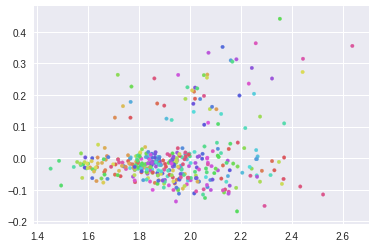

In [37]:
plt.scatter(state_diffs[:,0] + state_diffs[:,1], state_diffs[:,1], marker='.', c=colors)


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 676.13: 100%|██████████| 200000/200000 [00:03<00:00, 61575.34it/s]
Finished [100%]: Average ELBO = 676.12
100%|██████████| 50000/50000 [01:46<00:00, 467.29it/s]


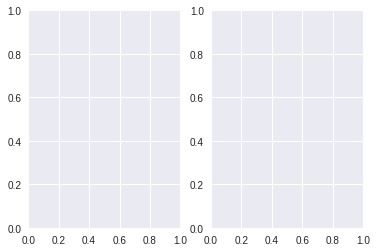

In [131]:
#mew  = 2.1
with  mc.Model() as model:
    mew = mc.Normal('mew',mu=2.1,sd=4.0)
    p = mc.Normal('p',mu=0.0,sd=1.0)
    s = mc.HalfNormal('s',sd=10.0)
    Y = mc.Normal('f_tp1', mu=(mew + p*(f_t-mew)),sd=s, observed=f_tp1)
    trace = mc.sample(50000)
    plt.figure()
    

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7ad34d50f0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f7ad29afa90>]], dtype=object)

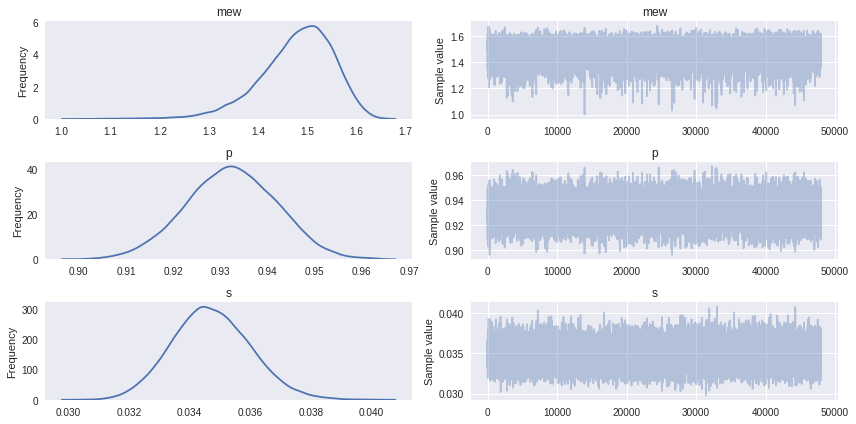

In [132]:
mc.traceplot(trace[2000:])

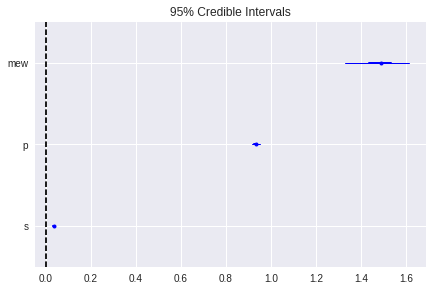

In [133]:
mc.forestplot(trace[2000:])

In [88]:
mew_mean = np.mean(trace['mew'][2000:])
p_mean   = np.mean(trace['p'][2000:])


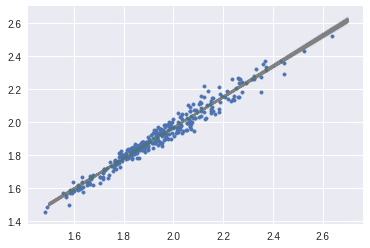

In [106]:
x=np.linspace(1.5,2.7,100)

for a in np.random.choice(trace[2000:], 1000):
    mew_s = a['mew']
    p_s   = a['p']
    prediction = mew_s + p_s*(x-mew_s)
    plt.plot(x,prediction, alpha=0.005, c='gray')
plt.scatter(f_t,f_tp1, marker='.')


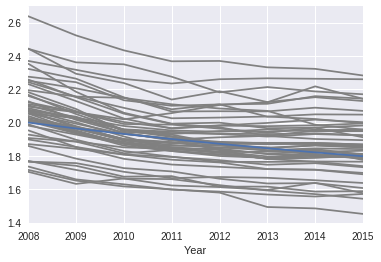

In [135]:
start=2.8
traj =[2.0]
years = np.unique(tfr.index.get_level_values(1))
for index,year in enumerate(years):
    traj.append( mew_mean + p_mean*(traj[index]-mew_mean))


ax=(tfr.unstack(level=0)
    .plot(legend=False, c='gray'))

ax.plot(years,traj[0:-1])


### hierarchical model

In [158]:
print(len(state_idx), len(f_t), len(f_tp1))

1326 357 357


In [221]:
n_states = len(np.unique(tfr.index.get_level_values(0)))

with  mc.Model() as hierarchical_model:
    
    mew_a = mc.Normal('mew_mean',mu=2.1,sd=20)
    mew_b = mc.Uniform('mu_std', lower=0, upper=100)
    
    p_a   = mc.Normal('p_mean',mu=0.93,sd=2)
    p_b   = mc.Uniform('p_std', lower=0, upper=100)

    
    mew = mc.Normal('mew',mu=mew_a,sd=mew_b, shape=n_states)
    p   = mc.Normal('p', mu=p_a, sd=p_b, shape=n_states )
    
    s = mc.HalfNormal('s',sd=10.0)
    Y = mc.Normal('f_tp1', mu=(mew[state_idx] + p[state_idx]*(f_t-mew[state_idx])),sd=s, observed=f_tp1)
    trace = mc.sample(50000)
    plt.figure()
    

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 680.51: 100%|██████████| 200000/200000 [00:46<00:00, 4268.96it/s]
Finished [100%]: Average ELBO = 680.41
100%|██████████| 50000/50000 [08:51<00:00, 94.10it/s]  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7ac50ddb38>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f7abff04400>]], dtype=object)

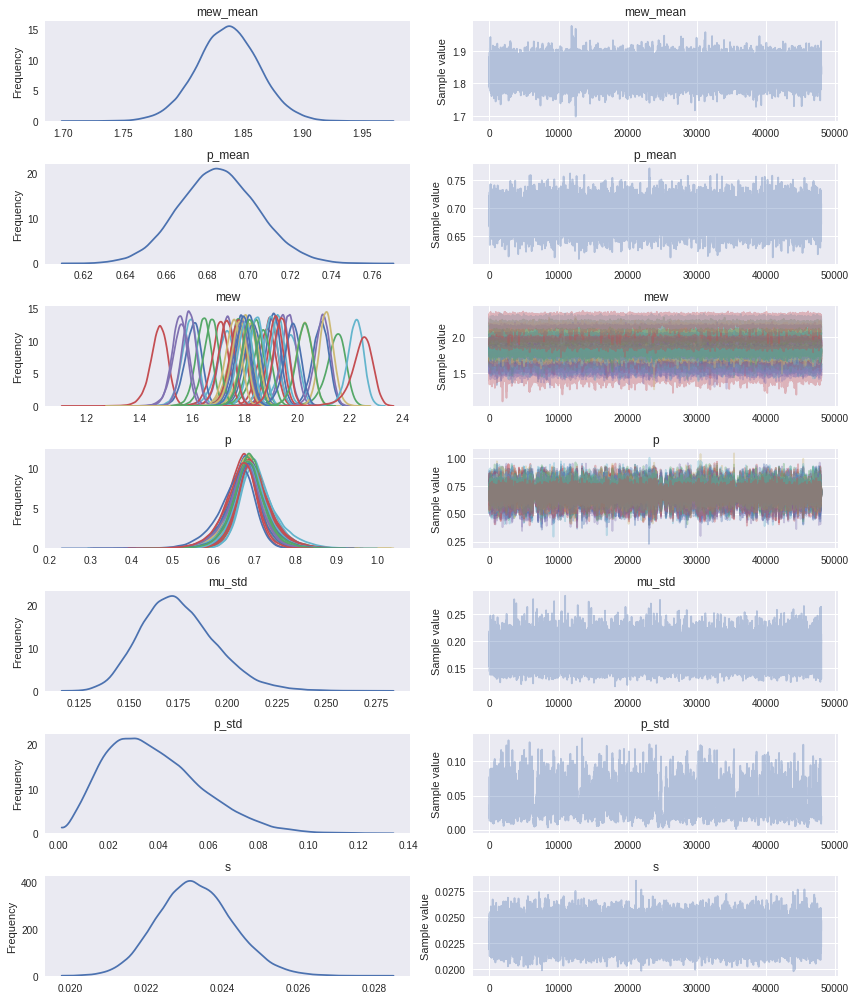

In [222]:
mc.traceplot(trace[2000:])

In [251]:
mc.forestplot??

In [256]:
plt.figure(figsize=(10,20))
hpds = mc.hpd(trace[2000:])

In [267]:
mc.forestplot??

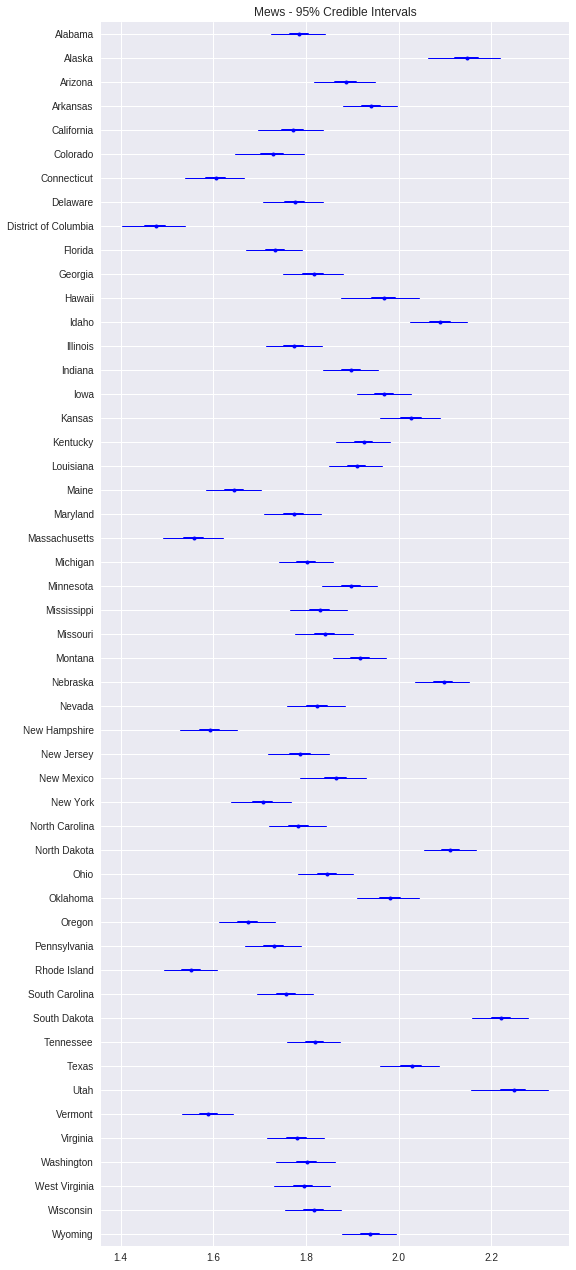

In [276]:
plt.figure(figsize=(10,20))
mc.forestplot(trace[2000:], ylabels=state_dict.keys(), varnames=['mew'], main='Mews - 95% Credible Intervals')


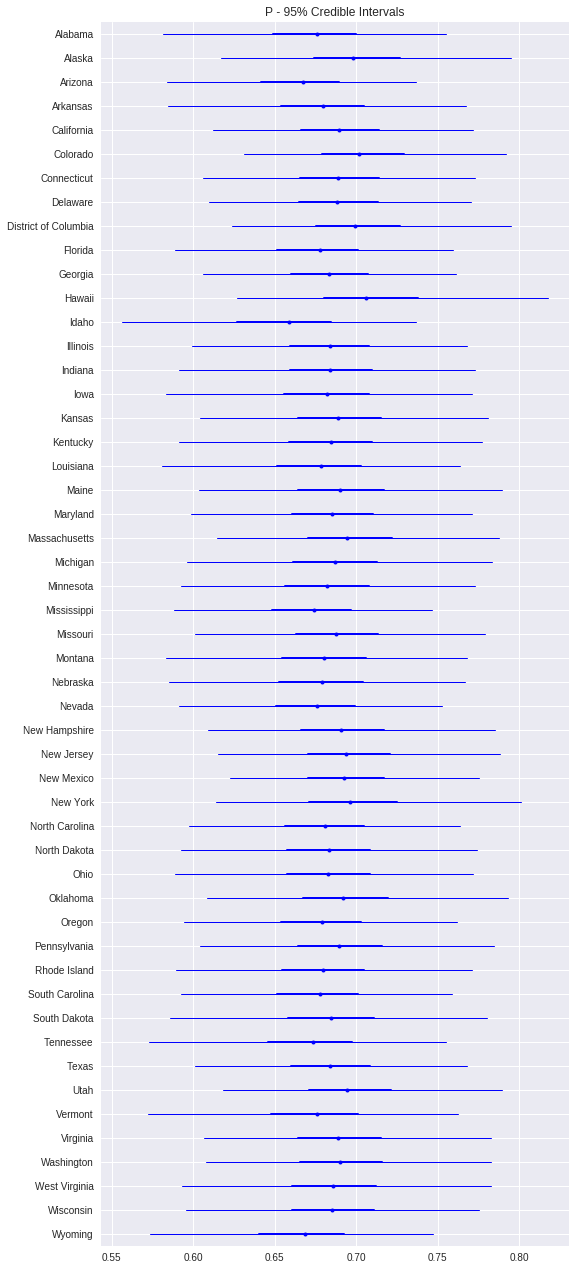

In [277]:
plt.figure(figsize=(10,20))
mc.forestplot(trace[2000:], ylabels=state_dict.keys(), varnames=['p'], main='P - 95% Credible Intervals')


In [284]:
pd.DataFrame(  {"hpd_lower":hpds['mew'][:,0], "hpd_upper":hpds['mew'][:,1], "mews":mews, 'state':list(state_dict.keys())}).to_csv('state_fertility_results.csv')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7abe4047f0>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x7f7abf661f60>]], dtype=object)

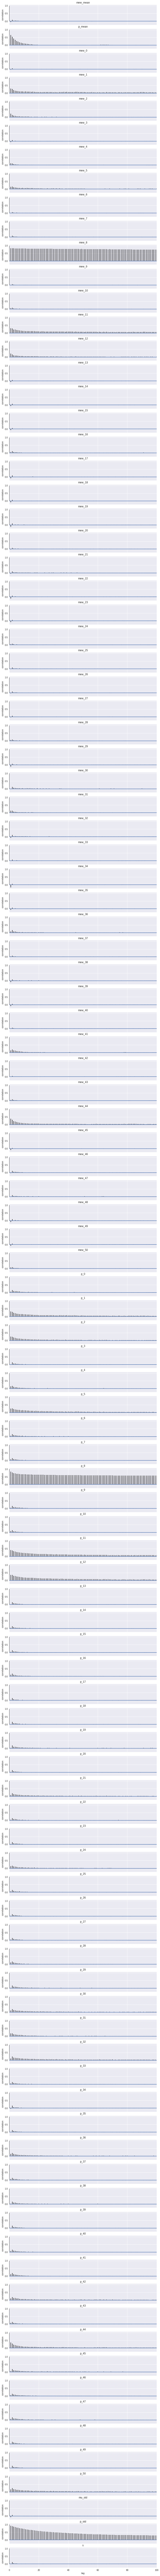

In [249]:
mc.autocorrplot(trace)

In [224]:
mews = [ np.mean(a) for a in trace['mew'].T]
ps   = [ np.mean(a) for a in trace['p'].T]

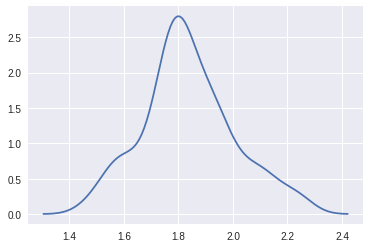

In [225]:
sbn.kdeplot(np.array(mews))

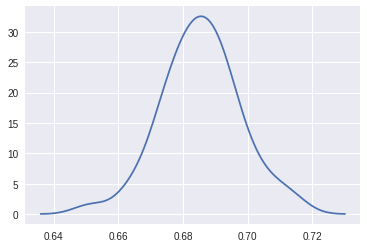

In [226]:
sbn.kdeplot(np.array(ps))

In [227]:
results=pd.DataFrame({"mews":mews, "ps":ps}, index=state_dict.keys())

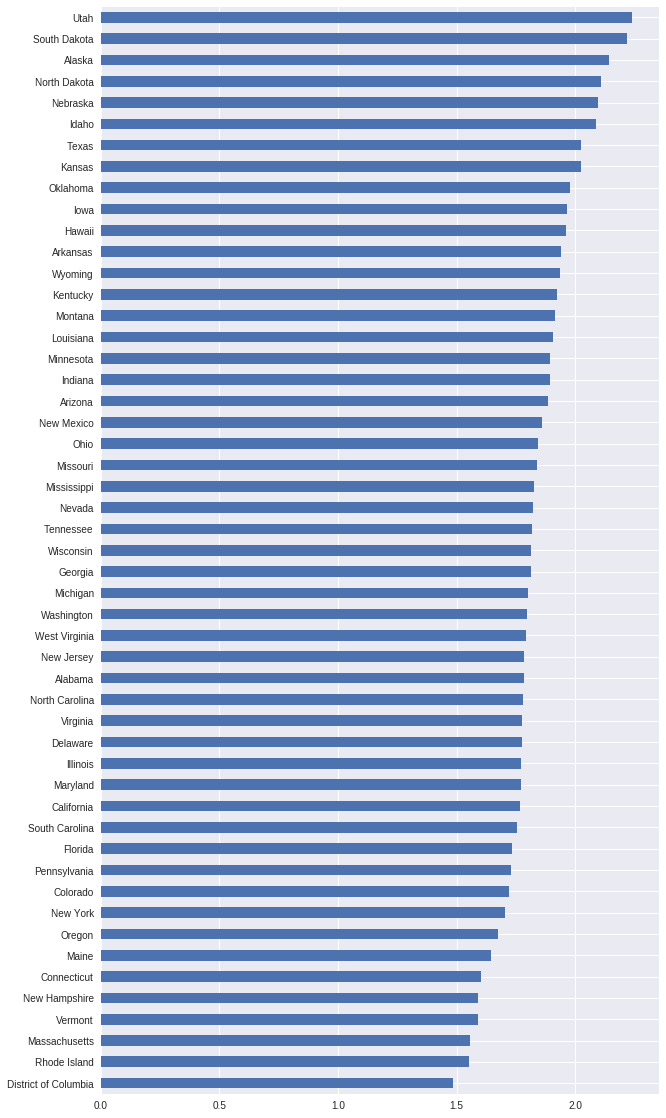

In [228]:
results['mews'].sort_values().plot(kind='barh', figsize=(10,20))

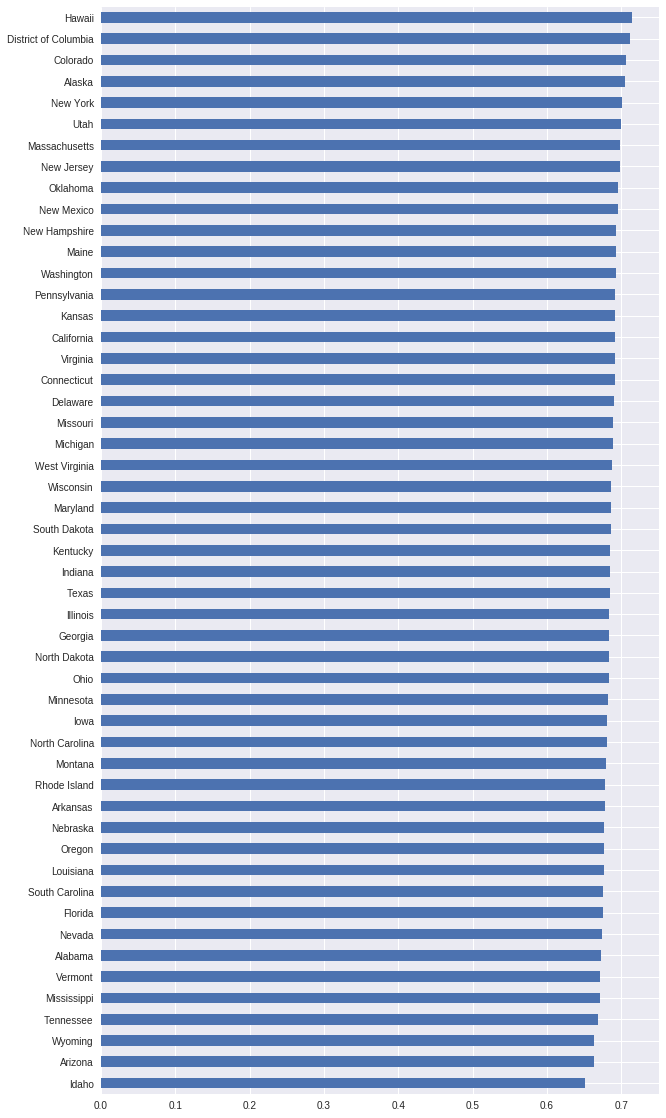

In [229]:
results['ps'].sort_values().plot(kind='barh', figsize=(10,20))

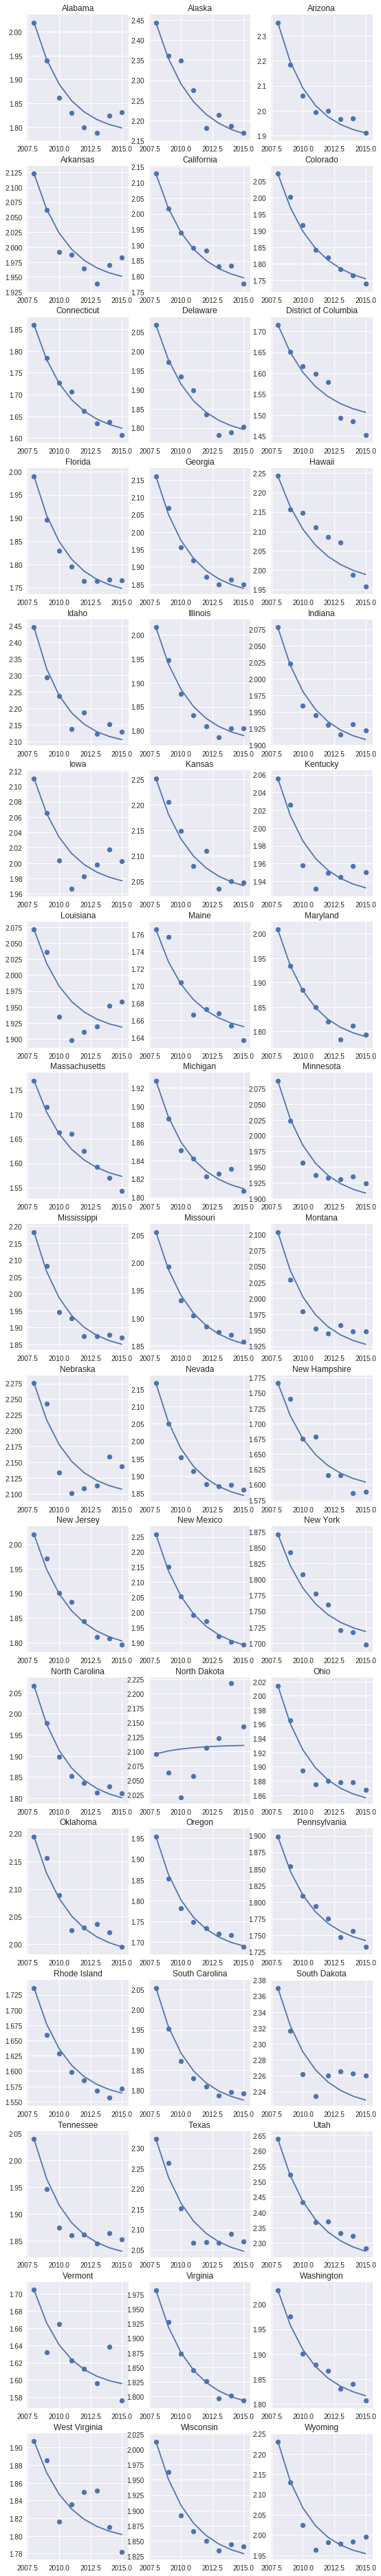

In [247]:
plt.figure()
x= years
start_year= years[0]
def plot_result(mew,ps,start, state):
    points = [ start ]
    for index,year in enumerate(years):
        points.append(mew + ps*(points[index]-mew) )
    plt.title(state)
    
    plt.plot(years,points[:-1])

plt.figure(figsize=(3*3,17*4))
plt_no=1
for index,row in results.iterrows():
    plt.subplot(17,3,plt_no)
    plot_result(row['mews'], row['ps'], tfr[index][start_year],index)
    plt.scatter(years, tfr[index].as_matrix(),label='state' )
    plt_no+=1

### Counties